[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1JOZgrE782OlTc7OS0ivUFlMdD6H2VhQC)

# Работа с NetworkX на примере набора данных "Титаник"

## Задание

Скачайте файл train.csv из набора данных "Титаник": https://www.kaggle.com/c/titanic/data. 

Сформируйте граф связей между пассажирами на основе двух признаков: общей каюты либо общей фамилии.

a. * Определите все изолированные сообщества в этом графе*

b. *Сформулируйте и проверьте гипотезу влияния размера сообщества в которое входит пассажир на целевую переменную (выживаемость в результате аварии)*

## Решение

Импортируем необходимые модули

In [0]:
from itertools import combinations
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np

Установим ```python-louvain``` для работы модуля ```community```



In [0]:
!pip install python-louvain

  Running setup.py bdist_wheel for python-louvain ... - done
  Stored in directory: /root/.cache/pip/wheels/c3/b0/db/198c7453d5169907dbdbb090eebc0c6839f75e36b09c6dc7aa
Successfully built python-louvain


In [0]:
!apt-get -qq install -y graphviz && pip install -q pydot
import pydot

Selecting previously unselected package fontconfig.
(Reading database ... 22280 files and directories currently installed.)
Preparing to unpack .../00-fontconfig_2.12.6-0ubuntu2_amd64.deb ...
Unpacking fontconfig (2.12.6-0ubuntu2) ...
Selecting previously unselected package libann0.
Preparing to unpack .../01-libann0_1.1.2+doc-6_amd64.deb ...
Unpacking libann0 (1.1.2+doc-6) ...
Selecting previously unselected package libcdt5.
Preparing to unpack .../02-libcdt5_2.40.1-2_amd64.deb ...
Unpacking libcdt5 (2.40.1-2) ...
Selecting previously unselected package libcgraph6.
Preparing to unpack .../03-libcgraph6_2.40.1-2_amd64.deb ...
Unpacking libcgraph6 (2.40.1-2) ...
Selecting previously unselected package libjbig0:amd64.
Preparing to unpack .../04-libjbig0_2.1-3.1build1_amd64.deb ...
Unpacking libjbig0:amd64 (2.1-3.1build1) ...
Selecting previously unselected package libtiff5:amd64.
Preparing to unpack .../05-libtiff5_4.0.9-5_amd64.deb ...
Unpacking libtiff5:amd64 (4.0.9-5) ...
Selecting pr

Грузим данные. Мною предварительно был загружен датасет на dropbox

In [0]:
!wget -O train.csv https://www.dropbox.com/s/89akkkgu0dz13u9/train.csv?dl=0

--2018-11-01 21:13:17--  https://www.dropbox.com/s/89akkkgu0dz13u9/train.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.7.1, 2620:100:601a:1::a27d:701
Connecting to www.dropbox.com (www.dropbox.com)|162.125.7.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/89akkkgu0dz13u9/train.csv [following]
--2018-11-01 21:13:17--  https://www.dropbox.com/s/raw/89akkkgu0dz13u9/train.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7344b413de61ef0d1d62d316ee.dl.dropboxusercontent.com/cd/0/inline/AUikStWZ22_hEw0oH4F_9qyyVSg0O_WubcLOgSUeffdL79mOdwh9XhLBdATSTlLI0z2iVH3CxChtX58SQQJeZ-KtpME1cUj75fVRZVBmZNtqed3BL7vFIA-ZkS_KaJLV83757VVZgDbBNA-zg4vI1VkuQN869pyVqAoeGuXr1-92xi6m7C-QBoKKlvm8N9Q1T2w/file [following]
--2018-11-01 21:13:17--  https://uc7344b413de61ef0d1d62d316ee.dl.dropboxusercontent.com/cd/0/inline/AUikStWZ22_hEw0oH4F_9qyyVSg0O_WubcLOgSUeffdL79mOdwh9XhL

Создаем DataFrame

In [0]:
df = pd.read_csv('train.csv', index_col='PassengerId')

In [0]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Создадим новый признак с фамилией

In [0]:
df['LastName'] = df['Name'].str.extract('([A-Za-z]+),', expand=False)

In [0]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LastName
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 12 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
LastName    891 non-null object
dtypes: float64(2), int64(4), object(6)
memory usage: 90.5+ KB


Видим, что у информация о каютах известна только для 204 пассажиров. Удаляем пассажиров с неизвестными каютами. И будут присоедины по общей фамилии

In [0]:
df_cab_notnull = df.dropna(subset=['Cabin'], how='all')

In [0]:
len(df_cab_notnull.index)

204

Приступаем к посторению графа. Находим пассажиров с одинаковой фамилий и строим полносвязный граф. Затем тоже самое и по общей каюте. И объединяем полученные группы, если это возможно. Серым цветом показана связь по фамилии, синим - по каюте.

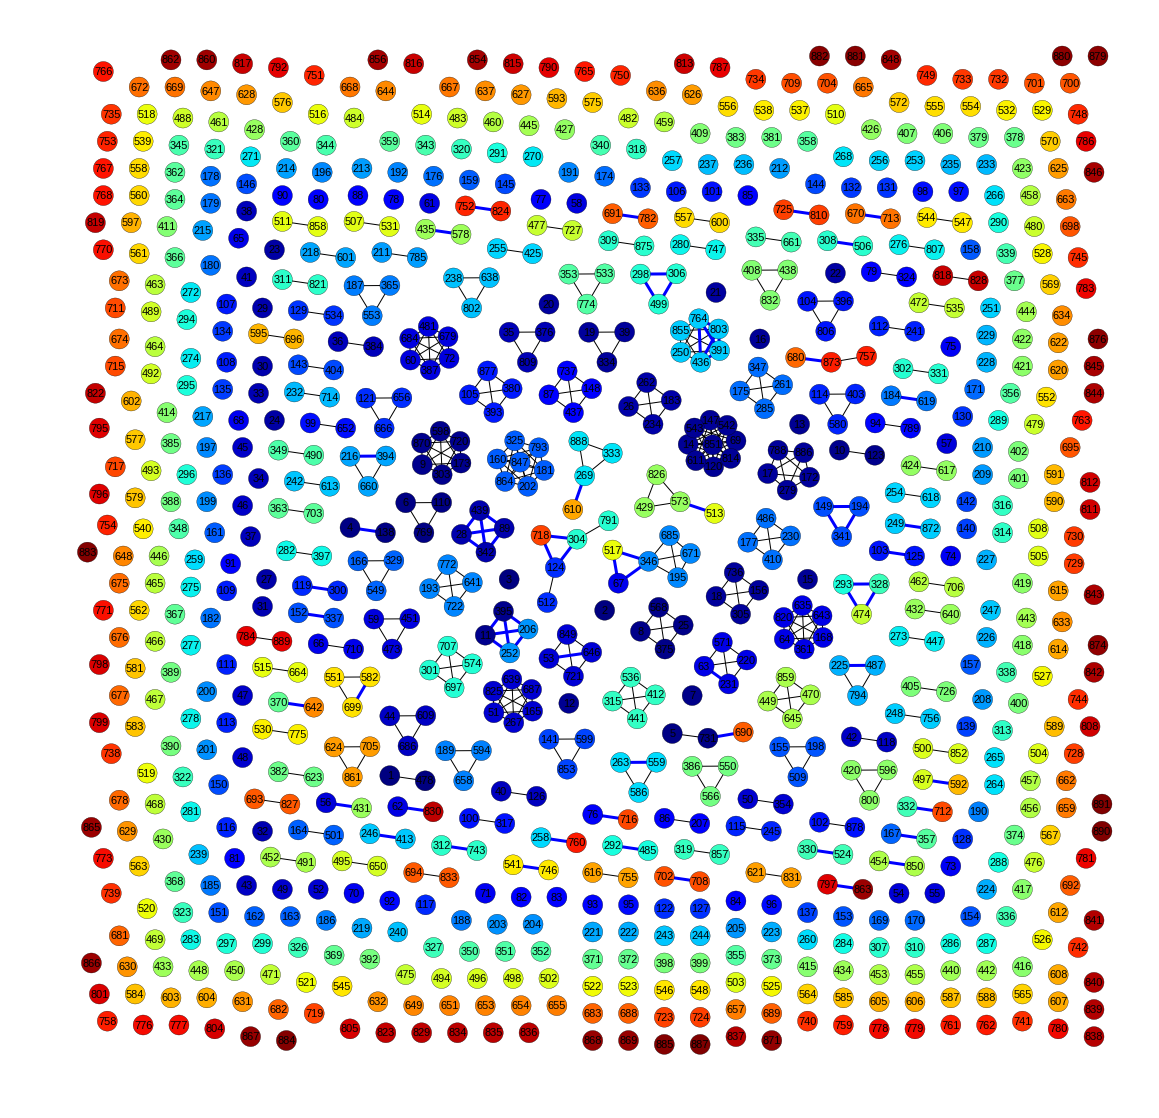

In [0]:

# создаем граф 
G = nx.Graph()
all_nodes = list(df.index)

G.add_nodes_from(all_nodes)

# список для раскраски вершин
node_colors = {k:0 for k in all_nodes}

inter_title_edges = []
plt.figure(figsize=(20,20))
# соединяем пассажиров с одинаковыми фамилиями 
for i, lname in enumerate(df['LastName'].unique()):
    nodes = list(df[df['LastName'] == lname].index)
    edges = combinations(nodes, 2)
    G.add_edges_from(edges)
    for node in nodes:
        node_colors[node] = i

# соединяем пассажиров с одинаковыми каютами
for i, cabin in enumerate(df_cab_notnull['Cabin'].unique()):
    nodes = list(df_cab_notnull[df_cab_notnull['Cabin'] == cabin].index)
    edges = list(combinations(nodes, 2))
    G.add_edges_from(edges)
    inter_title_edges += edges

# рисуем
clr_list = [node_colors[n] for n in G.nodes()]
pos = nx.drawing.nx_pydot.pydot_layout(G,)
nx.draw_networkx_nodes(G, pos,cmap = plt.get_cmap("jet"), node_color=clr_list, node_size=400, edgecolors='k')
nx.draw_networkx_labels(G, pos,font_size=11)
nx.draw_networkx_edges(G, pos) # рисуем все ребра графа
nx.draw_networkx_edges(G, pos, edgelist=inter_title_edges, width=3, edge_color='b',) # соединяем вершины графа ребрами синего цвета, если пассажиры имеют общую каюту
plt.axis('off')
plt.show()

С помощью модуля `community` выделим независымые группы

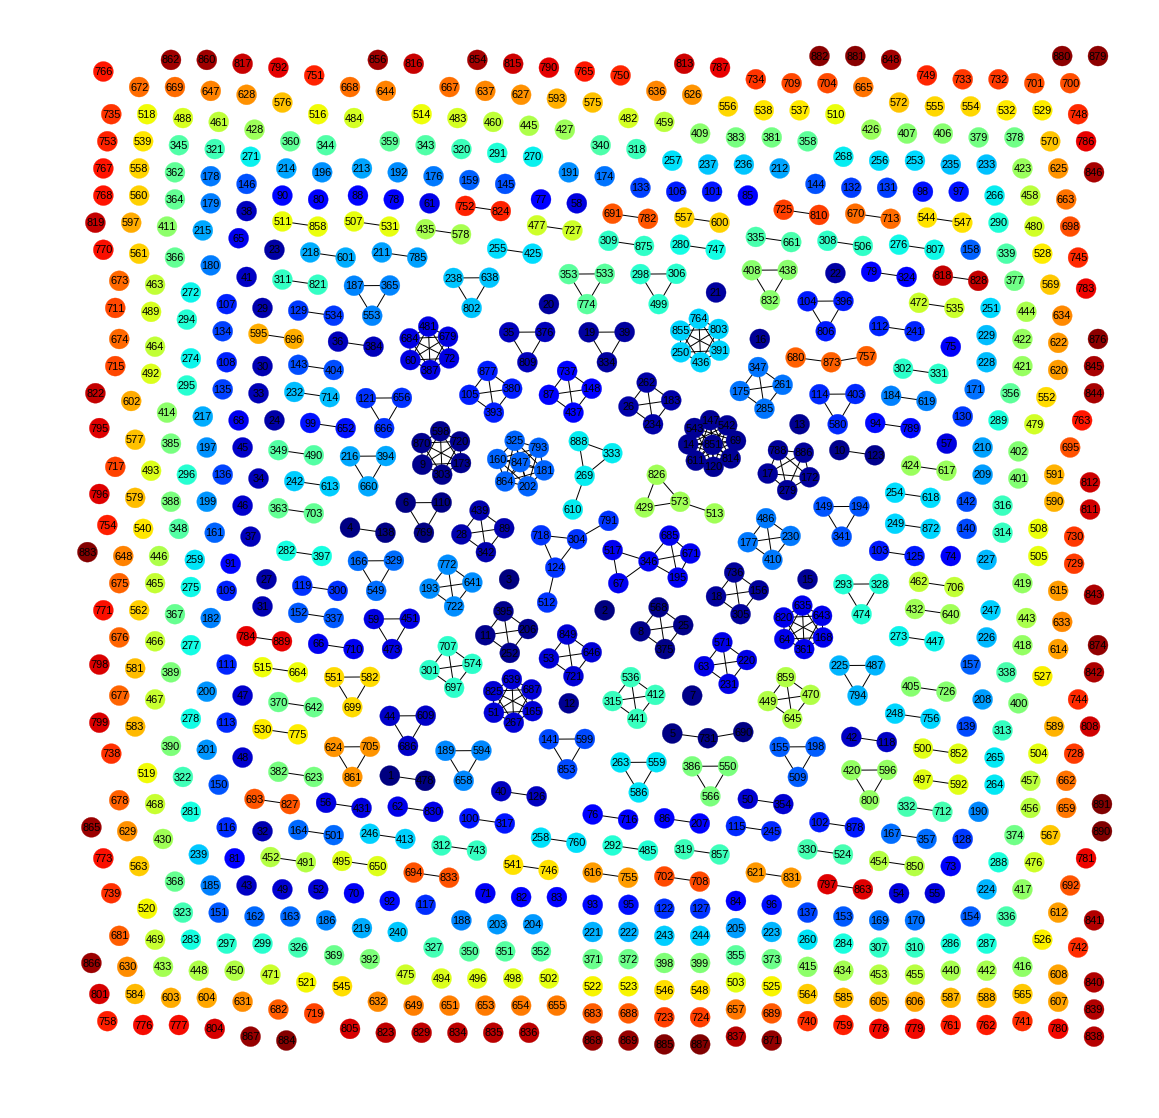

In [0]:
import community
parts = community.best_partition(G)
values = [parts.get(node) for node in G.nodes()]
plt.figure(figsize=(20,20))
plt.axis("off")
nx.draw_networkx(G, pos = pos, cmap = plt.get_cmap("jet"), node_color = values, node_size = 400, font_size=11)

In [0]:
print(f"Количесво изолированныйх сообществ (включая одиноких пассажиров): {len(set(values))}") # или len(set(parts.values()))

Количесво изолированныйх сообществ (включая одиноких пассажиров): 645


Но по определению [Сообщество](https://ru.wikipedia.org/wiki/Сообщество) - это группа людей, следовательно одиноких пассажиров следует исключить

Сделаем копию нашего графа

In [0]:
G_copy = G.copy()

Удалим пассажира, если у него нет "друзей"

In [0]:
for node in G.nodes():
  if not(len(list(G.neighbors(node)))):
    
    G_copy.remove_node(node)

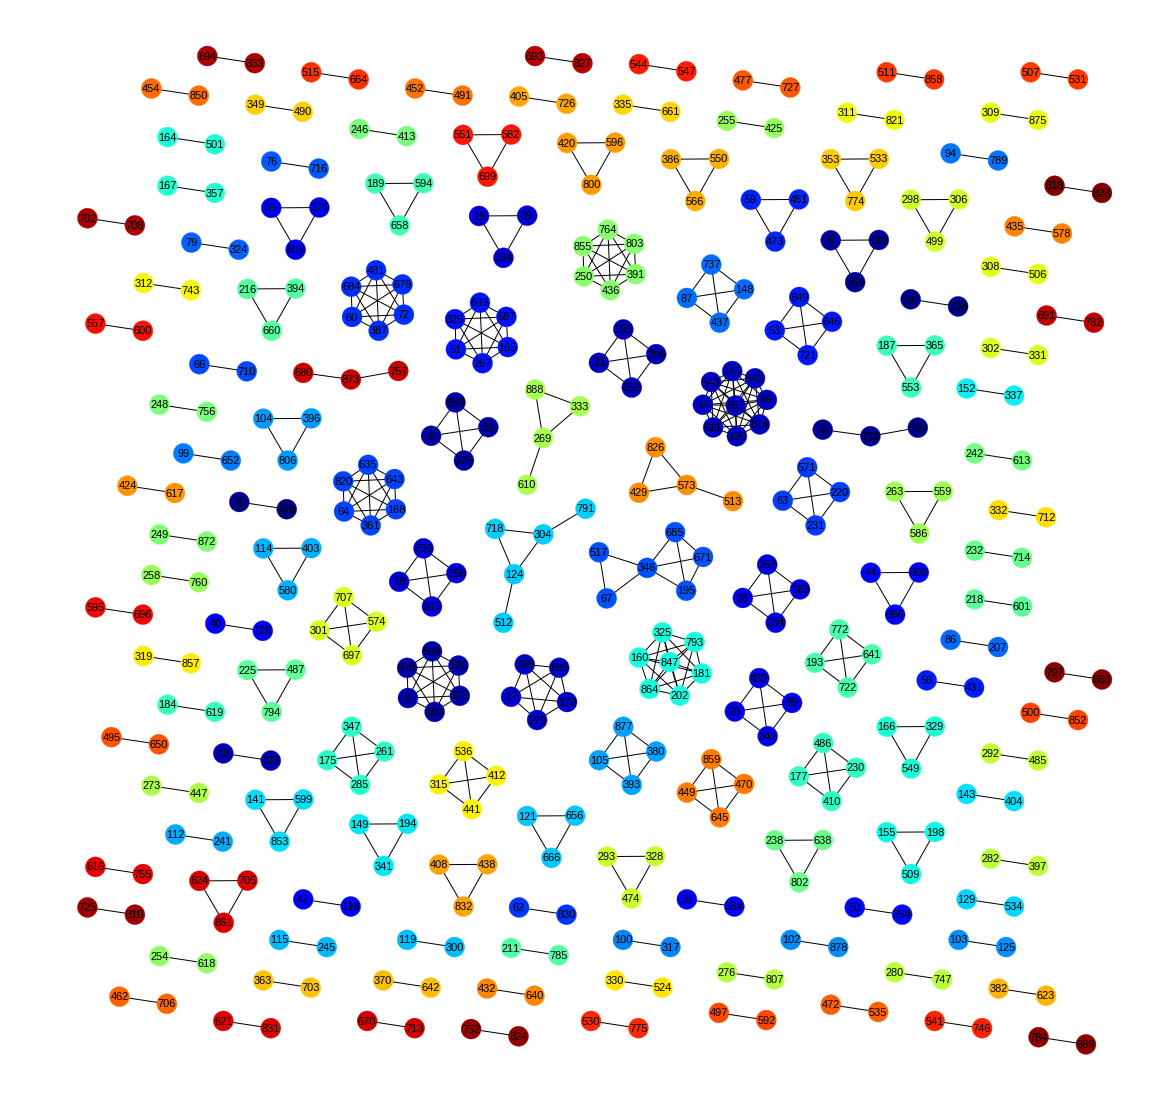

In [0]:
parts = community.best_partition(G_copy)
values = [parts.get(node) for node in G_copy.nodes()]
plt.figure(figsize=(20,20))
plt.axis("off")
nx.draw_networkx(G_copy, pos = nx.drawing.nx_pydot.pydot_layout(G_copy), cmap = plt.get_cmap("jet"), node_color = values, node_size = 400, font_size=11)

In [0]:
print(f"Количесво изолированныйх сообществ: {len(set(values))}") # или len(set(parts.values()))

Количесво изолированныйх сообществ: 142


Сформулируем гипотезу: чем больше человек в группе , тем выше шансы выжить. Предположение основано на том, что работая в "команде" каждый человек имеет большую решимость, смелость и способностью к сотрудничеству. Легче координировать действия. 


Добавляем к нашему DataFrame новый принак** `"Количесво соседей"`**

In [0]:
count_neighbors = [len(list(G.neighbors(i))) for i in range(1,892)]

In [0]:
len(count_neighbors)

891

In [0]:
df['CountNeighbors'] = count_neighbors

In [0]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LastName,CountNeighbors
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,1
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,1


In [0]:
survival_of_neighbors = df[["CountNeighbors", "Survived"]].groupby(['CountNeighbors'], as_index=False).mean().sort_values(by='CountNeighbors', ascending=False)

Процент выживаемости от количества соседей

In [0]:
survival_of_neighbors

,CountNeighbors,Survived
7,8,0.222222
6,6,0.000000
5,5,0.258065
4,4,0.000000
3,3,0.447761
2,2,0.390805
1,1,0.560440
0,0,0.330020


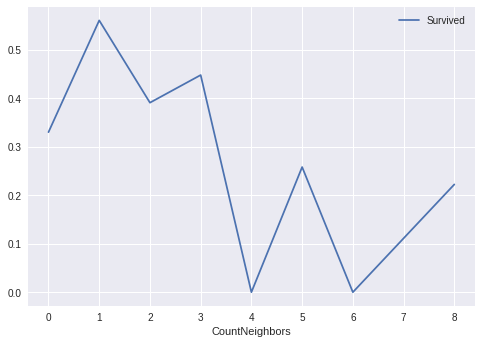

In [0]:
survival_of_neighbors.plot(x='CountNeighbors', y='Survived')

Как видно из графика выше, шанс выжить у одиночек и небольших групп значительно выше, чем у групп с четырмя и более человек. 